In [346]:
## Handwritten digit identifier.
## Joe Dobrow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
plt.rcParams['figure.figsize'] = (4.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [347]:
# MNIST dataset found through Kaggle and downloaded to my local desktop
# https://www.kaggle.com/c/digit-recognizer
test_data = pd.read_csv('/Users/jdobrow/Desktop/Data Science/digit-recognizer/test.csv')
train_data = pd.read_csv('/Users/jdobrow/Desktop/Data Science/digit-recognizer/train.csv')

# Re-organizing train data into separate arrays for each image
xtrain = train_data.drop(['label'], axis=1).values
xtrain = xtrain.reshape(xtrain.shape[0], 28, 28)
ytrain = np.array(train_data['label'])

xtest = test_data.values
xtest = xtest.reshape(xtest.shape[0], 28, 28)

df = pd.DataFrame()
df['label'] = ytrain
test_df = pd.DataFrame()

In [ ]:
###  DATA CLEANING ###

In [348]:
# This 'sharpens' the images for simplicity. Makes each pixel either 1 (on) or 0 (off). This results in
# significant information loss but simplifies the feature engineering process. Note: Setting this threshold
# to different numbers between 0 and 254 could dramatically affect the performance of the eventual models
# and I haven't played much with it yet

threshold = 80

for i in range(len(xtrain)):
    for j in range(28):
        for k in range(28):
            if xtrain[i][j][k] > threshold:
                xtrain[i][j][k] = 1
            else:
                xtrain[i][j][k] = 0
                
for i in range(len(xtest)):
    for j in range(28):
        for k in range(28):
            if xtest[i][j][k] > threshold:
                xtest[i][j][k] = 1
            else:
                xtest[i][j][k] = 0

In [ ]:
### Functions ###

In [349]:
# Given an image, a pixel coordinates on that image, and a direction, this returns whether or not if you
# start at that pixel and head in that direction to the edge of the image if you'll make it to the edge.
# This function is used to help determine if a pixel is surrounded.
# 1 == up, 2 == right, 3 == down, 4 == left

def goesToWall(img, pixel, direction):

    if img[pixel[0]][pixel[1]] == 1:
        return False
    else:
        if direction == 1:
            for i in range(pixel[0]):
                if img[i][pixel[1]] == 1:
                    return False
            return True
        elif direction == 3:
            for i in range(28 - pixel[0]):
                if img[27 - i][pixel[1]]:
                    return False
            return True
        elif direction == 4:
            for i in range(pixel[1]):
                if img[pixel[0]][i] == 1:
                    return False
            return True
        else:
            for i in range(28 - pixel[1]):
                if img[pixel[0]][27 - i] == 1:
                    return False
            return True
        
# Used to help condense images to 6x6 to help with dimensionality of features later
def checkRange(img, istart, iend, jstart, jend):
    
    for i in range(istart, iend):
        for j in range(jstart, jend):
            try:
                if img[i][j] == 1:
                    return True
            except:
                None
    return False

# Finds and returns the next empty pixel in an image
def findNext(img):
    for i in range(28):
        for j in range(28):
            if img[i][j] == 0:
                return [[i,j]]
    return None

In [ ]:
### FEATURE ENGINEERING

In [363]:
# Counts the 'on' pixels in the image.
total_pixels = []
for i in range(len(xtrain)):
    pixel_count = 0
    for j in range(len(xtrain[i])):
        for k in range(len(xtrain[i][j])):
            if xtrain[i][j][k] > 0:
                pixel_count += 1
    total_pixels.append(pixel_count)

df['NumberPositivePixels'] = total_pixels

total_pixels = []
for i in range(len(xtest)):
    pixel_count = 0
    for j in range(len(xtest[i])):
        for k in range(len(xtest[i][j])):
            if xtest[i][j][k] > 0:
                pixel_count += 1
    total_pixels.append(pixel_count)
    
test_df['NumberPositivePixels'] = total_pixels 

In [364]:
# Counts the 'vertical edges' or any white pixel that has a black pixel directly above it. Also the horizontal.
vertical_pixels = []
horizontal_pixels = []
for i in range(len(xtrain)):
    countv = 0
    counth = 0
    for j in range(28):
        for k in range(28):
            try:
                if (xtrain[i][j+1][k] == 0) & (xtrain[i][j][k] == 1):
                    countv += 1
            except:
                None
            try:
                if (xtrain[i][j][k+1] == 0) & (xtrain[i][j][k] == 1):
                    counth += 1
            except:
                None
    vertical_pixels.append(countv)
    horizontal_pixels.append(counth)
df['VerticalEdges'] = vertical_pixels
df['HorizontalEdges'] = horizontal_pixels

vertical_pixels = []
horizontal_pixels = []
for i in range(len(xtest)):
    countv = 0
    counth = 0
    for j in range(28):
        for k in range(28):
            try:
                if (xtest[i][j+1][k] == 0) & (xtest[i][j][k] == 1):
                    countv += 1
            except:
                None
            try:
                if (xtest[i][j][k+1] == 0) & (xtest[i][j][k] == 1):
                    counth += 1
            except:
                None
    vertical_pixels.append(countv)
    horizontal_pixels.append(counth)
test_df['VerticalEdges'] = vertical_pixels
test_df['HorizontalEdges'] = horizontal_pixels

In [365]:
# Height of digit.
heights = []
for img in range(len(xtrain)):
    height = 0
    for i in range(28):
        for j in range(28):
            if xtrain[img][i][j] == 1:
                height += 1
                break
    heights.append(height)
df['Height'] = heights
        
heights = []
for img in range(len(xtest)):
    height = 0
    for i in range(28):
        for j in range(28):
            if xtest[img][i][j] == 1:
                height += 1
                break
    heights.append(height)
test_df['Height'] = heights

In [366]:
# Width of digit.
widths = []
for img in range(len(xtrain)):
    width = 0
    for i in range(28):
        for j in range(28):
            if xtrain[img][j][i] == 1:
                width += 1
                break
    widths.append(width)
df['Width'] = widths
        
widths = []
for img in range(len(xtest)):
    width = 0
    for i in range(28):
        for j in range(28):
            if xtest[img][j][i] == 1:
                width += 1
                break
    widths.append(width)
test_df['Width'] = widths

In [367]:
# This alrogithm reflect the image and then counts the number of pixels that match the original.
# To find how much it reflects, I need to first find the line of reflection. A 'greedy' algorithm should work.
# Note: this feature is not that strong and could be potentially revisited.
y_reflect = []
for img in range(len(xtrain)):
    closest = 784
    pixel_count = 0
    for j in range(28):
        for k in range(28):
            if xtrain[img][j][k] > 0:
                pixel_count += 1
    for i in range(6,28):
        side_pixel_count = 0
        for j in range(i, 28):
            for k in range(28):
                if xtrain[img][j][k] > 0:
                    side_pixel_count += 1
        if abs(pixel_count/2 - side_pixel_count) <= closest:
            closest = (abs(pixel_count/2 - side_pixel_count))
        else:
            line_reflection = i
            break

    count=0
    for j in range(28):
        for k in range(28):
            try:
                if (xtrain[img][j][k] == 1) & (xtrain[img][2*line_reflection - j][k] == 1):
                    count += 1
            except:
                None
    y_reflect.append(count)
df['YReflect'] = y_reflect

y_reflect = []
for img in range(len(xtest)):
    closest = 784
    pixel_count = 0
    for j in range(28):
        for k in range(28):
            if xtest[img][j][k] > 0:
                pixel_count += 1
    for i in range(6,28):
        side_pixel_count = 0
        for j in range(i, 28):
            for k in range(28):
                if xtest[img][j][k] > 0:
                    side_pixel_count += 1
        if abs(pixel_count/2 - side_pixel_count) <= closest:
            closest = (abs(pixel_count/2 - side_pixel_count))
        else:
            line_reflection = i
            break

    count=0
    for j in range(28):
        for k in range(28):
            try:
                if (xtest[img][j][k] == 1) & (xtest[img][2 * line_reflection - j][k] == 1):
                    count += 1
            except:
                None
    y_reflect.append(count)
test_df['YReflect'] = y_reflect

In [368]:
x_reflect = []
for img in range(len(xtrain)):
    closest = 784
    pixel_count = 0
    for j in range(28):
        for k in range(28):
            if xtrain[img][j][k] > 0:
                pixel_count += 1
    for i in range(6,28):
        side_pixel_count = 0
        for j in range(28):
            for k in range(i, 28):
                if xtrain[img][j][k] > 0:
                    side_pixel_count += 1
        if abs(pixel_count/2 - side_pixel_count) <= closest:
            closest = (abs(pixel_count/2 - side_pixel_count))
        else:
            line_reflection = i
            break

    count=0
    for j in range(28):
        for k in range(28):
            try:
                if (xtrain[img][j][k] == 1) & (xtrain[img][j][2*line_reflection - k] == 1):
                    count += 1
            except:
                None
    x_reflect.append(count)
df['XReflect'] = x_reflect

x_reflect = []
for img in range(len(xtest)):
    closest = 784
    pixel_count = 0
    for j in range(28):
        for k in range(28):
            if xtest[img][j][k] > 0:
                pixel_count += 1
    for i in range(6,28):
        side_pixel_count = 0
        for j in range(28):
            for k in range(i, 28):
                if xtest[img][j][k] > 0:
                    side_pixel_count += 1
        if abs(pixel_count/2 - side_pixel_count) <= closest:
            closest = (abs(pixel_count/2 - side_pixel_count))
        else:
            line_reflection = i
            break

    count=0
    for j in range(28):
        for k in range(28):
            try:
                if (xtest[img][j][k] == 1) & (xtest[img][j][2*line_reflection - k] == 1):
                    count += 1
            except:
                None
    x_reflect.append(count)
test_df['XReflect'] = x_reflect

In [369]:
# For each black pixel, determine how many of the 4 edges of the image that the pixel has a direct line towards
# without crossing any white pixels. NoneToWalls are effectively contained, and FourToWalls are in the corners
# of the image where they have a line of sight to all 4 walls.
none_counts = []
one_counts = []
two_counts = []
three_counts = []
four_counts = []
for img in xtrain:
    count_none = 0
    count_one = 0
    count_two = 0
    count_three = 0
    count_four = 0
    for i in range(28):
        for j in range(28):
            if img[i][j] == 0:
                count = 0
                for k in range(4):
                    if goesToWall(img, [i,j], k+1):
                        count += 1  
                if count == 0:
                    count_none += 1
                elif count == 1:
                    count_one += 1
                elif count == 2:
                    count_two += 1
                elif count == 3:
                    count_three += 1
                elif count == 4:
                    count_four += 1
    none_counts.append(count_none)
    one_counts.append(count_one)
    two_counts.append(count_two)
    three_counts.append(count_three)
    four_counts.append(count_four)
df['NoneToWall'] = none_counts
df['OneToWall'] = one_counts
df['TwoToWall'] = two_counts
df['ThreeToWall'] = three_counts
df['FourToWall'] = four_counts

none_counts = []
one_counts = []
two_counts = []
three_counts = []
four_counts = []
for img in xtest:
    count_none = 0
    count_one = 0
    count_two = 0
    count_three = 0
    count_four = 0
    for i in range(28):
        for j in range(28):
            if img[i][j] == 0:
                count = 0
                for k in range(4):
                    if goesToWall(img, [i,j], k+1):
                        count += 1  
                if count == 0:
                    count_none += 1
                elif count == 1:
                    count_one += 1
                elif count == 2:
                    count_two += 1
                elif count == 3:
                    count_three += 1
                elif count == 4:
                    count_four += 1
    none_counts.append(count_none)
    one_counts.append(count_one)
    two_counts.append(count_two)
    three_counts.append(count_three)
    four_counts.append(count_four)
test_df['NoneToWall'] = none_counts
test_df['OneToWall'] = one_counts
test_df['TwoToWall'] = two_counts
test_df['ThreeToWall'] = three_counts
test_df['FourToWall'] = four_counts


In [370]:
# For the pixels that are 'OneToWall,' which of the four walls do they have a line of sight towards?
# 1 == up, 2 == right, 3 == down, 4 == left
upcounts = []
rightcounts = []
downcounts = []
leftcounts = []
for img in xtrain:
    upcount = 0
    rightcount = 0
    downcount = 0
    leftcount = 0
    for i in range(28):
        for j in range(28):
            if img[i][j] == 0:
                if (goesToWall(img, [i,j], 1)) and not (goesToWall(img, [i,j], 2)) and not (goesToWall(img, [i,j], 3)) and not (goesToWall(img, [i,j], 4)):
                    upcount += 1
                elif (goesToWall(img, [i,j], 2)) and not (goesToWall(img, [i,j], 1)) and not (goesToWall(img, [i,j], 3)) and not (goesToWall(img, [i,j], 4)):
                    rightcount += 1
                elif (goesToWall(img, [i,j], 3)) and not (goesToWall(img, [i,j], 2)) and not (goesToWall(img, [i,j], 1)) and not (goesToWall(img, [i,j], 4)):
                    downcount += 1
                elif (goesToWall(img, [i,j], 4)) and not (goesToWall(img, [i,j], 2)) and not (goesToWall(img, [i,j], 3)) and not (goesToWall(img, [i,j], 1)):
                    leftcount += 1
    upcounts.append(upcount)
    rightcounts.append(rightcount)
    downcounts.append(downcount)
    leftcounts.append(leftcount)
df['GoesToTopOnly'] = upcounts
df['GoesToRightOnly'] = rightcounts
df['GoesToDownOnly'] = downcounts
df['GoesToLeftOnly'] = leftcounts

# 1 == up, 2 == right, 3 == down, 4 == left
upcounts = []
rightcounts = []
downcounts = []
leftcounts = []
for img in xtest:
    upcount = 0
    rightcount = 0
    downcount = 0
    leftcount = 0
    for i in range(28):
        for j in range(28):
            if img[i][j] == 0:
                if (goesToWall(img, [i,j], 1)) and not (goesToWall(img, [i,j], 2)) and not (goesToWall(img, [i,j], 3)) and not (goesToWall(img, [i,j], 4)):
                    upcount += 1
                elif (goesToWall(img, [i,j], 2)) and not (goesToWall(img, [i,j], 1)) and not (goesToWall(img, [i,j], 3)) and not (goesToWall(img, [i,j], 4)):
                    rightcount += 1
                elif (goesToWall(img, [i,j], 3)) and not (goesToWall(img, [i,j], 2)) and not (goesToWall(img, [i,j], 1)) and not (goesToWall(img, [i,j], 4)):
                    downcount += 1
                elif (goesToWall(img, [i,j], 4)) and not (goesToWall(img, [i,j], 2)) and not (goesToWall(img, [i,j], 3)) and not (goesToWall(img, [i,j], 1)):
                    leftcount += 1
    upcounts.append(upcount)
    rightcounts.append(rightcount)
    downcounts.append(downcount)
    leftcounts.append(leftcount)
test_df['GoesToTopOnly'] = upcounts
test_df['GoesToRightOnly'] = rightcounts
test_df['GoesToDownOnly'] = downcounts
test_df['GoesToLeftOnly'] = leftcounts

In [371]:
# Counts the number of 'curved pixels' in an image. A curved pixel is defined by having 
# exactly 2 of its 4 adjacent pixels white. This is a fairly weak feature, but still contributes.

curved_pixels = []
for img in range(len(xtrain)):
    curvy_count = 0
    for i in range(28):
        for j in range(28):
            if xtrain[img][i][j] == 1:
                count = 0
                try:
                    if xtrain[img][i + 1][j] == 1:
                        count += 1
                except:
                    None
                try:
                    if xtrain[img][i - 1][j] == 1:
                        count += 1
                except:
                    None
                try:
                    if xtrain[img][i][j + 1] == 1:
                        count += 1
                except:
                    None
                try:
                    if xtrain[img][i][j - 1] == 1:
                        count += 1
                except:
                    None
                if count == 2:
                    curvy_count += 1
    curved_pixels.append(curvy_count)
df['CurvedPixels'] = curved_pixels

curved_pixels = []
for img in range(len(xtest)):
    curvy_count = 0
    for i in range(28):
        for j in range(28):
            if xtest[img][i][j] == 1:
                count = 0
                try:
                    if xtest[img][i + 1][j] == 1:
                        count += 1
                except:
                    None
                try:
                    if xtest[img][i - 1][j] == 1:
                        count += 1
                except:
                    None
                try:
                    if xtest[img][i][j + 1] == 1:
                        count += 1
                except:
                    None
                try:
                    if xtest[img][i][j - 1] == 1:
                        count += 1
                except:
                    None
                if count == 2:
                    curvy_count += 1
    curved_pixels.append(curvy_count)
test_df['CurvedPixels'] = curved_pixels

In [372]:
# for each row of the image, how many times does it switch colors as it transerves the image? Then take an average.
horizontal_averages = []
for img in xtrain:
    horizontal_change = 0
    count = 0
    for i in range(28):
        flips = 0
        for j in range(28):
            if j == 0:
                state = img[i][j]
            else:
                if img[i][j] != state:
                    state = img[i][j]
                    flips += 1
        if flips > 0:
            count += 1
        horizontal_change += flips
    horizontal_averages.append(horizontal_change/count)
df['HorizontalFlips'] = horizontal_averages

horizontal_averages = []
for img in xtest:
    horizontal_change = 0
    count = 0
    for i in range(28):
        flips = 0
        for j in range(28):
            if j == 0:
                state = img[i][j]
            else:
                if img[i][j] != state:
                    state = img[i][j]
                    flips += 1
        if flips > 0:
            count += 1
        horizontal_change += flips
    horizontal_averages.append(horizontal_change/count)
test_df['HorizontalFlips'] = horizontal_averages

In [373]:
# The same but for vertical slices of the image.
vertical_averages = []
for img in xtrain:
    vertical_change = 0
    count = 0
    for i in range(28):
        flips = 0
        for j in range(28):
            if j == 0:
                state = img[j][i]
            else:
                if img[j][i] != state:
                    state = img[j][i]
                    flips += 1
        if flips > 0:
            count += 1
        vertical_change += flips
    vertical_averages.append(vertical_change/count)
df['VerticalFlips'] = vertical_averages

vertical_averages = []
for img in xtest:
    vertical_change = 0
    count = 0
    for i in range(28):
        flips = 0
        for j in range(28):
            if j == 0:
                state = img[j][i]
            else:
                if img[j][i] != state:
                    state = img[j][i]
                    flips += 1
        if flips > 0:
            count += 1
        vertical_change += flips
    vertical_averages.append(vertical_change/count)
test_df['VerticalFlips'] = vertical_averages

In [374]:
# Determines the number of seperate black areas of the image.
area_counts = []
for i in xtrain:
    img = i.copy()
    img[0][0] = 1
    active = [[0,0]]
    new_active = []
    go = 1
    areas_count = 1
    iteration = 0
    while go == 1:
        for coor in active:
            img[coor[0]][coor[1]] = 1
            try:
                if img[coor[0] + 1][coor[1]] == 0:
                    new_active.append([coor[0] + 1, coor[1]])
                    img[coor[0] + 1][coor[1]] = 1
            except:
                None
            try:
                if img[coor[0] - 1][coor[1]] == 0:
                    new_active.append([coor[0] - 1, coor[1]])
                    img[coor[0] - 1][coor[1]] = 1
            except:
                None
            try:
                if img[coor[0]][coor[1] + 1] == 0:
                    new_active.append([coor[0], coor[1] + 1])
                    img[coor[0]][coor[1] + 1] = 1
            except:
                None
            try:
                if img[coor[0]][coor[1] - 1] == 0:
                    new_active.append([coor[0], coor[1] - 1])
                    img[coor[0]][coor[1] - 1] = 1
            except:
                None
        if len(new_active) == 0:
            complete = 1
            for i in range(28):
                for j in range(28):
                    complete *= img[i][j]
            if complete == 1:
                go = 0
            else:
                if iteration > 0:
                    areas_count += 1
                active = (findNext(img))
                new_active = []
                iteration = 0
        else:
            active = new_active
            new_active = []
            iteration += 1
    area_counts.append(areas_count)
df['AreaCounts'] = area_counts

area_counts = []
for i in xtest:
    img = i.copy()
    img[0][0] = 1
    active = [[0,0]]
    new_active = []
    go = 1
    areas_count = 1
    iteration = 0
    while go == 1:
        for coor in active:
            img[coor[0]][coor[1]] = 1
            try:
                if img[coor[0] + 1][coor[1]] == 0:
                    new_active.append([coor[0] + 1, coor[1]])
                    img[coor[0] + 1][coor[1]] = 1
            except:
                None
            try:
                if img[coor[0] - 1][coor[1]] == 0:
                    new_active.append([coor[0] - 1, coor[1]])
                    img[coor[0] - 1][coor[1]] = 1
            except:
                None
            try:
                if img[coor[0]][coor[1] + 1] == 0:
                    new_active.append([coor[0], coor[1] + 1])
                    img[coor[0]][coor[1] + 1] = 1
            except:
                None
            try:
                if img[coor[0]][coor[1] - 1] == 0:
                    new_active.append([coor[0], coor[1] - 1])
                    img[coor[0]][coor[1] - 1] = 1
            except:
                None
        if len(new_active) == 0:
            complete = 1
            for i in range(28):
                for j in range(28):
                    complete *= img[i][j]
            if complete == 1:
                go = 0
            else:
                if iteration > 0:
                    areas_count += 1
                active = (findNext(img))
                new_active = []
                iteration = 0
        else:
            active = new_active
            new_active = []
            iteration += 1
    area_counts.append(areas_count)
test_df['AreaCounts'] = area_counts

In [375]:
# Condensing the images by first slimming them and then mapping them onto a 6 x 6 image. cutting off 2 pixel from each side
condensed_train = []
for img in range(len(sharper_xtrain)):
    condensed_train.append(np.zeros((6,6)))
    for i in range(6):
        for j in range(6):
            if checkRange(sharper_xtrain[img], 2 + 4*i, 6 + 4*i, 2 + 4*j, 6 + 4*j):
                condensed_train[img][i][j] = 1

condensed_test = []
for img in range(len(sharper_xtest)):
    condensed_test.append(np.zeros((6,6)))
    for i in range(6):
        for j in range(6):
            if checkRange(sharper_xtest[img], 2 + 4*i, 6 + 4*i, 2 + 4*j, 6 + 4*j):
                condensed_test[img][i][j] = 1
        

In [376]:
# Making each of the 36 pixels in the condensed images a feature.
for i in range(36):
    on_list = []
    for img in range(len(condensed_train)):
        on_list.append(condensed_train[img][i%6][i//6])
    df['CondPix' + str(i)] = on_list
    
for i in range(36):
    on_list = []
    for img in range(len(condensed_test)):
        on_list.append(condensed_test[img][i%6][i//6])
    test_df['CondPix' + str(i)] = on_list

In [377]:
# Creating a couple features through a linear combination of two other features. Then scaling all features that
# should be functions of the number of white pixels in the image and deleting the non-scaled features.
df['ExtraVerticals'] = abs(df['VerticalEdges'] - df['Width'])
df['ExtraHorizontals'] = abs(df['HorizontalEdges'] - df['Height'])
df['ScaledExtraVerticals'] = abs(df['VerticalEdges'] - df['Width'])/df['NumberPositivePixels']
df['ScaledExtraHorizontals'] = abs(df['HorizontalEdges'] - df['Height'])/df['NumberPositivePixels']
df['ScaledVerticalEdges'] = df['VerticalEdges']/df['NumberPositivePixels']
df['ScaledHorizontalEdges'] = df['HorizontalEdges']/df['NumberPositivePixels']
df['ScaledYReflect'] = df['YReflect']/df['NumberPositivePixels']
df['ScaledXReflect'] = df['XReflect']/df['NumberPositivePixels']
df['ScaledNoneToWall'] = df['NoneToWall']/(784 - df['NumberPositivePixels'])
df['ScaledNoneToWall'] = df['NoneToWall']/(784 - df['NumberPositivePixels'])
df['ScaledOneToWall'] = df['OneToWall']/(784 - df['NumberPositivePixels'])
df['ScaledTwoToWall'] = df['TwoToWall']/(784 - df['NumberPositivePixels'])
df['ScaledThreeToWall'] = df['ThreeToWall']/(784 - df['NumberPositivePixels'])
df['ScaledFourToWall'] = df['FourToWall']/(784 - df['NumberPositivePixels'])
df['ScaledCurvedPixels'] = df['CurvedPixels']/df['NumberPositivePixels']
df['ScaledGoesToTopOnly'] = df['GoesToTopOnly']/df['NumberPositivePixels']
df['ScaledGoesToRightOnly'] = df['GoesToRightOnly']/df['NumberPositivePixels']
df['ScaledGoesToDownOnly'] = df['GoesToDownOnly']/df['NumberPositivePixels']
df['ScaledGoesToLeftOnly'] = df['GoesToLeftOnly']/df['NumberPositivePixels']
df.drop(['VerticalEdges', 'HorizontalEdges', 'ExtraVerticals', 'ExtraHorizontals', 'HorizontalEdges', 'YReflect', 'XReflect', 'NoneToWall', 'OneToWall', 'TwoToWall', 'ThreeToWall', 'FourToWall', 'CurvedPixels', 'GoesToTopOnly', 'GoesToRightOnly', 'GoesToDownOnly', 'GoesToLeftOnly'], 1, inplace=True)
df.to_csv('/Users/jdobrow/Desktop/Data Science/Capstone 3 Files/df')

In [378]:
# Doing the same for the test data
test_df['ExtraVerticals'] = abs(test_df['VerticalEdges'] - test_df['Width'])
test_df['ExtraHorizontals'] = abs(test_df['HorizontalEdges'] - test_df['Height'])
test_df['ScaledExtraVerticals'] = abs(test_df['VerticalEdges'] - test_df['Width'])/test_df['NumberPositivePixels']
test_df['ScaledExtraHorizontals'] = abs(test_df['HorizontalEdges'] - test_df['Height'])/test_df['NumberPositivePixels']
test_df['ScaledVerticalEdges'] = test_df['VerticalEdges']/test_df['NumberPositivePixels']
test_df['ScaledHorizontalEdges'] = test_df['HorizontalEdges']/test_df['NumberPositivePixels']
test_df['ScaledYReflect'] = test_df['YReflect']/test_df['NumberPositivePixels']
test_df['ScaledXReflect'] = test_df['XReflect']/test_df['NumberPositivePixels']
test_df['ScaledNoneToWall'] = test_df['NoneToWall']/(784 - test_df['NumberPositivePixels'])
test_df['ScaledNoneToWall'] = test_df['NoneToWall']/(784 - test_df['NumberPositivePixels'])
test_df['ScaledOneToWall'] = test_df['OneToWall']/(784 - test_df['NumberPositivePixels'])
test_df['ScaledTwoToWall'] = test_df['TwoToWall']/(784 - test_df['NumberPositivePixels'])
test_df['ScaledThreeToWall'] = test_df['ThreeToWall']/(784 - test_df['NumberPositivePixels'])
test_df['ScaledFourToWall'] = test_df['FourToWall']/(784 - test_df['NumberPositivePixels'])
test_df['ScaledCurvedPixels'] = test_df['CurvedPixels']/test_df['NumberPositivePixels']
test_df['ScaledGoesToTopOnly'] = test_df['GoesToTopOnly']/test_df['NumberPositivePixels']
test_df['ScaledGoesToRightOnly'] = test_df['GoesToRightOnly']/test_df['NumberPositivePixels']
test_df['ScaledGoesToDownOnly'] = test_df['GoesToDownOnly']/test_df['NumberPositivePixels']
test_df['ScaledGoesToLeftOnly'] = test_df['GoesToLeftOnly']/test_df['NumberPositivePixels']
test_df.drop(['VerticalEdges', 'HorizontalEdges', 'ExtraVerticals', 'ExtraHorizontals', 'HorizontalEdges', 'YReflect', 'XReflect', 'NoneToWall', 'OneToWall', 'TwoToWall', 'ThreeToWall', 'FourToWall', 'CurvedPixels', 'GoesToTopOnly', 'GoesToRightOnly', 'GoesToDownOnly', 'GoesToLeftOnly'], 1, inplace=True)
test_df.to_csv('/Users/jdobrow/Desktop/Data Science/Capstone 3 Files/test_df')

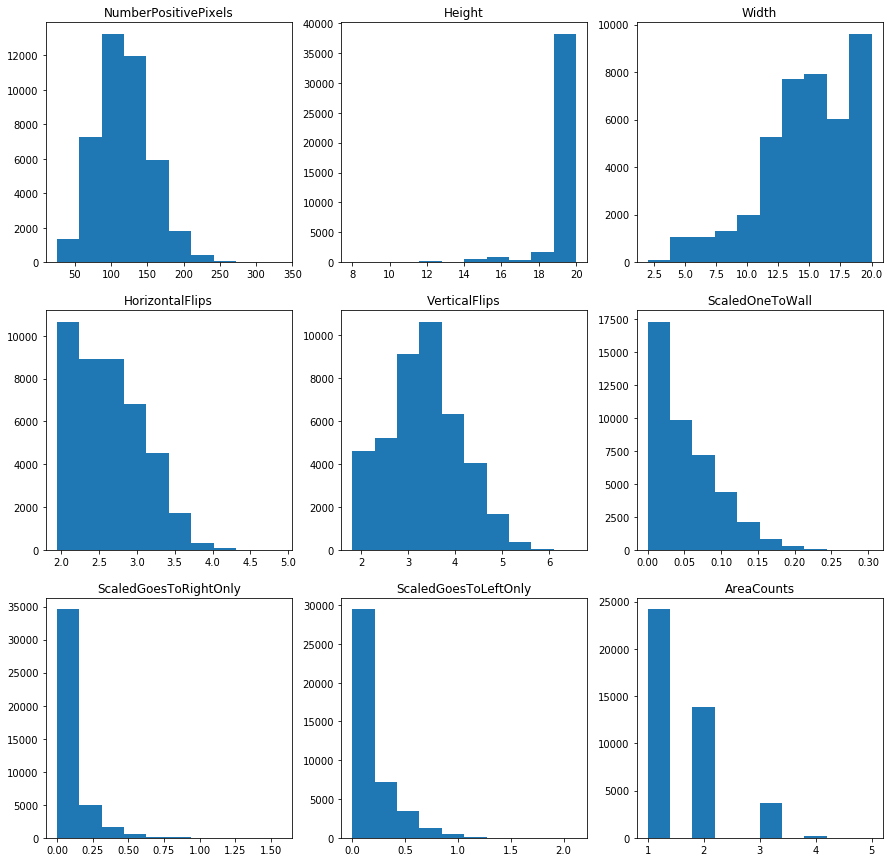

In [379]:
# Visualizing some of the feature distributions
fig, axs = plt.subplots(3,3, figsize=(15,15))

good_features = ['NumberPositivePixels', 'Height', 'Width', 'HorizontalFlips', 'VerticalFlips', 'ScaledOneToWall', 'ScaledGoesToRightOnly', 'ScaledGoesToLeftOnly', 'AreaCounts']

for i in range(9):
    axs[i//3, i%3].hist(df[good_features[i]])
    axs[i//3, i%3].set_title(good_features[i])

plt.show()